# Programming Exercise: Lorenz Curves and Gini Coefficients

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

This notebook contains some programming exercises related to the Lorenz curve
and the Gini coefficient, which are often used to study inequality.

Your task will be to compute these curves and values, replicating functionality
that already exists in `quantecon`.

Uncomment the following if necessary

In [17]:
#!pip install quantecon 

We use the following imports.

In [18]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

## Preamble: The Lorenz curve and Gini coefficient

### Definition

Let $w_1, \ldots, w_n$ be a sample of observations of wealth (or income, or
consumption, or firm sizes, etc.) in a population.

Suppose the sample has been sorted from smallest to largest.

The Lorenz curve takes this sample and produces a curve $L$.

To create it we first generate data points $(x_i, y_i)_{i=0}^n$  according to

$$
    x_0 = y_0 = 0
    \qquad \text{and, for $i \geq 1$,} \quad
    x_i = \frac{i}{n},
    \qquad
    y_i =
       \frac{\sum_{j \leq i} w_j}{\sum_{j \leq n} w_j}  
$$

Now the Lorenz curve $L$ is formed from these data points using interpolation.

The meaning of the statement $y = L(x)$ is that the lowest $(100 \times x)$\% of
people have $(100 \times y)$\% of all wealth.

* if $x=0.5$ and $y=0.1$, then the bottom 50% of the population
  owns 10% of the wealth.

### Using QuantEcon's routine

Let's look at an example.

First we generate $n=2000$ draws from a lognormal distribution and treat these draws as our population.

In [19]:
n = 2000
sample = np.exp(np.random.randn(n))       # Lognormal sample

We then generate the Lorenz curve using a routine from `quantecon`.

In [20]:
x, y = qe.lorenz_curve(sample)            # QuantEcon routine (no need to sort)

Now `x` and `y` contain the sample points $x_i$, $y_i$.

Let's plot, allowing Matplotlib to provide the interpolation.

The straight line ($x=L(x)$ for all $x$) corresponds to perfect equality.  

The lognormal draws produce a less equal distribution.

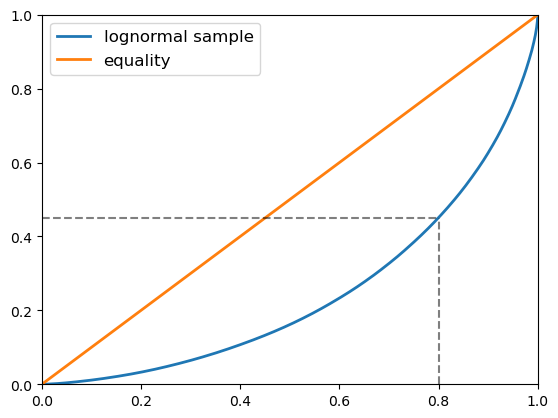

In [21]:
fig, ax = plt.subplots()
ax.plot(x, y, label=f'lognormal sample', lw=2)
ax.plot(x, x, label='equality', lw=2)
ax.legend(fontsize=12)
ax.set_ylim((0, 1))
ax.set_xlim((0, 1))
j = 1600  # dashed lines for j-th element
ax.vlines(x[j], [0.0], y[j], alpha=0.5, colors='k', ls='--')
ax.hlines(y[j], [0], x[j], alpha=0.5, colors='k', ls='--')
plt.show()

For example, if we imagine these draws as being observations of wealth across a
sample of households, then the dashed lines show that the bottom 80\% of
households own just over 40\% of total wealth.


**Exercise**

Using the definition of the Lorenz curve given above and NumPy, try to write
your own version of `qe.lorenz_curve`.  

* If possible, accelerate your code with Numba

Try to replicate the figure above, using the same lognormal data set.

In [22]:

n = 2000
sorted_sample = np.sort(np.exp(np.random.randn(n)))       # Lognormal sorted sample

In [23]:
def lorenz_curve(w):
    n = len(w)

In [24]:
x = np.zeros(n)
y = np.zeros(n)

for i in range(1, n):

    x[i] = i / n
    y[i] = np.sum(sorted_sample[0:i-1]) / np.sum(sorted_sample)
    

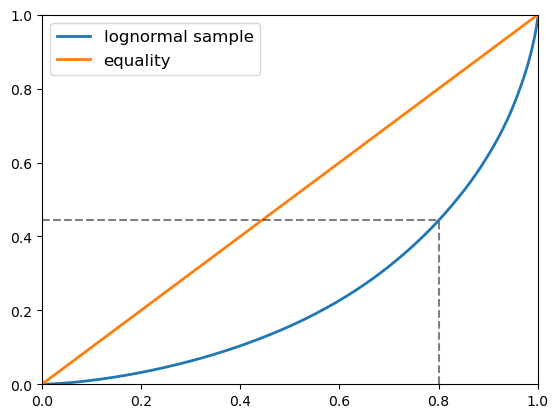

In [25]:
fig, ax = plt.subplots()
ax.plot(x, y, label=f'lognormal sample', lw=2)
ax.plot(x, x, label='equality', lw=2)
ax.legend(fontsize=12)
ax.set_ylim((0, 1))
ax.set_xlim((0, 1))
j = 1600  # dashed lines for j-th element
ax.vlines(x[j], [0.0], y[j], alpha=0.5, colors='k', ls='--')
ax.hlines(y[j], [0], x[j], alpha=0.5, colors='k', ls='--')
plt.show()

In [26]:
n = 2000
sample = np.exp(np.random.randn(n))       # Lognormal sample

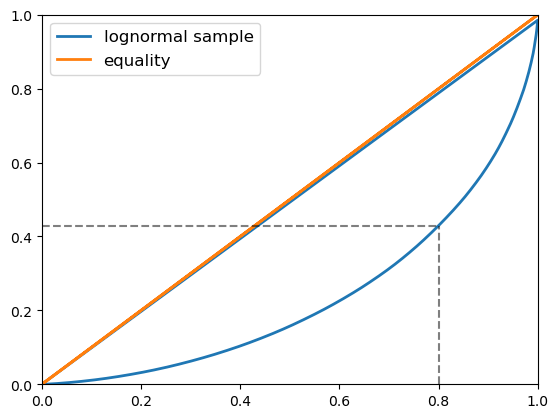

In [27]:
def lorenz_curve(w):
    n = len(w)
    w = np.sort(w)
    x = np.zeros(n + 1)
    y = np.zeros(n + 1)
    running_sum = w[0]
    total_sum = np.sum(w)
    for i in range(1, n):
        x[i] = i / n
        y[i] = running_sum / total_sum
        running_sum += w[i]
    return x, y

x, y = lorenz_curve(sample)    # Our routine

fig, ax = plt.subplots()
ax.plot(x, y, label=f'lognormal sample', lw=2)
ax.plot(x, x, label='equality', lw=2)
ax.legend(fontsize=12)
ax.set_ylim((0, 1))
ax.set_xlim((0, 1))
j = 1600  # dashed lines for j-th element
ax.vlines(x[j], [0.0], y[j], alpha=0.5, colors='k', ls='--')
ax.hlines(y[j], [0], x[j], alpha=0.5, colors='k', ls='--')
plt.show()

In [28]:
numba_lorenz_curve = numba.jit(lorenz_curve)

In [29]:
from time import time

In [30]:
start_time = time()
x, y = lorenz_curve(sample)
elapsed = time() - start_time
elapsed

0.0008797645568847656

In [31]:
start_time = time()
x, y = numba_lorenz_curve(sample)
numba_elapsed = time() - start_time
numba_elapsed

0.11000180244445801

In [32]:
numba_elapsed / elapsed - 1

124.03550135501355

## The Gini coefficient

### Definition

Continuing to assume that $w_1, \ldots, w_n$ has been sorted from smallest to largest,
the Gini coefficient of the sample is defined by

$$
    G :=
    \frac
        {\sum_{i=1}^n \sum_{j = 1}^n |w_j - w_i|}
        {2n\sum_{i=1}^n w_i}.
$$


### Using QuantEcon's routine

Let's examine the Gini coefficient in some simulations using `gini_coefficient`
from `quantecon`.

The following code computes the Gini coefficients for five different populations.

Each of these populations is generated by drawing from a lognormal distribution with parameters $\mu$ (mean) and $\sigma$ (standard deviation).

To create the five populations, we vary $\sigma$ over a grid of length $5$
between $0.2$ and $4$.

In each case we set $\mu = - \sigma^2 / 2$, so that the mean of the distribution does not change with $\sigma$.

In [33]:
k = 5
σ_vals = np.linspace(0.2, 4, k)
n = 2_000
ginis = []
for σ in σ_vals:
    # Generate the data
    μ = -σ**2 / 2
    y = np.exp(μ + σ * np.random.randn(n))
    # Calculate the Gini coefficient
    ginis.append(qe.gini_coefficient(y))

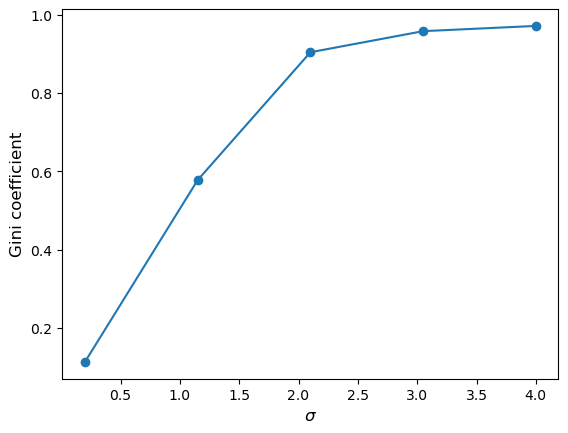

In [34]:
fig, ax = plt.subplots()
ax.plot(σ_vals, ginis, marker='o')
ax.set_xlabel('$\sigma$', fontsize=12)
ax.set_ylabel('Gini coefficient', fontsize=12)
plt.show()

The plots show that inequality rises with $\sigma$ (as measured by the Gini coefficient).

**Exercise**

Using the definition above and NumPy, try to write your own version of
`qe.gini_coefficient`.  

* Try to replicate the figure above.
* Accelerate your code with Numba.
* If possible, parallelize one of the loops.


In [35]:
k = 5
σ_vals = np.linspace(0.2, 4, k)
n = 2_000
ginis = []
for σ in σ_vals:
    # Generate the data
    μ = -σ**2 / 2
    y = np.exp(μ + σ * np.random.randn(n))
    # Calculate the Gini coefficient
    num = 0.0
    for i in range(n):
        for j in range(n):
            num += abs(w[i] - w[j])
            
    return num / (2 * n * np.sum(w))

SyntaxError: 'return' outside function (4282535397.py, line 15)

**Solution**

Here's one solution, without parallelization

In [36]:
@numba.jit
def gini_coefficient(w):
    n = len(w)
    s = 0.0
    for i in range(n):
        for j in range(n):
            s += abs(w[i] - w[j])
    return s / (2 * n * np.sum(w))

In [37]:
sample = np.exp(np.random.randn(100_000_000))
#gini_coefficient(sample)

In [ ]:
%time gini_coefficient(sample)

Here's another, with parallelization

In [38]:
@numba.jit(parallel=True)
def gini_coefficient(w):
    n = len(w)
    s = 0.0
    for i in numba.prange(n):
        for j in range(n):
            s += abs(w[i] - w[j])
    return s / (2 * n * np.sum(w))

In [ ]:
gini_coefficient(sample)

In [ ]:
%time gini_coefficient(sample)

In [ ]:
ginis = []

for σ in σ_vals:
    μ = -σ**2 / 2
    y = np.exp(μ + σ * np.random.randn(n))
    ginis.append(gini_coefficient(y))


fig, ax = plt.subplots()
ax.plot(σ_vals, ginis, marker='o')
ax.set_xlabel('$\sigma$', fontsize=12)
ax.set_ylabel('Gini coefficient', fontsize=12)
plt.show()